In [180]:
import pandas as pd
import geopandas as gpd
import shapely
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from geoalchemy2 import Geometry, WKTElement
import  sqlalchemy 
from scipy.optimize import lsq_linear
from shapely.geometry import MultiLineString

pd.options.display.max_rows = 200
pd.options.display.max_columns = 200

pg = open('db_credentials.txt')
db = pg.read()
pg.close()
engine = sqlalchemy.create_engine(db)

LIST OF VALUES
VALUE 1
Roadway Type
DESCRIPTION Street
VALUE 2
DESCRIPTION Highway
VALUE 3
DESCRIPTION Bridge
VALUE 4
DESCRIPTION Tunnel
VALUE 5
DESCRIPTION Boardwalk
VALUE 6
DESCRIPTION Path/Trail
VALUE 7
DESCRIPTION Step Street
VALUE 8
DESCRIPTION Driveway
VALUE 9
DESCRIPTION Ramp
VALUE 10
DESCRIPTION Alley
VALUE 11
DESCRIPTION Unknown
VALUE 12
DESCRIPTION Non-Physical Street Segment
VALUE 13
DESCRIPTION U-Turn
VALUE 14
DESCRIPTION Ferry Route

VALUE 0
DESCRIPTION Street other than vehicle only street.
VALUE 1
DESCRIPTION Railroad
VALUE 2
DESCRIPTION Water Edge / Shoreline
VALUE 3
DESCRIPTION Census Block Boundary
VALUE 5
DESCRIPTION Paper Street: This is a legally mapped, but unbuilt street. Such streets are
common in areas of Staten Island anticipating development. May exist in all boroughs.
VALUE 6
DESCRIPTION Private Street: This is a physically existing street which is not owned by the
City and is not officially mapped. For example, streets in the Fort Totten and Breezy Point
sections of Queens.
VALUE 7
DESCRIPTION District Boundary: Physically non-existent boundary for a community district, a
police precinct, or a fire company.
VALUE 8
DESCRIPTION Physical Non-Street Boundary: Physically existing un-addressable boundary
(such as a rock wall cemetery edge).
VALUE 9
DESCRIPTION Paper Street and Census/District Boundary: A legally mapped, but unbuilt
street that also acts as a census block or district boundary.
VALUE A
DESCRIPTION Alley: a narrow street or passageway between and behind city buildings.
VALUE W
DESCRIPTION Path, Non-Vehicular, Addressable: This is a walking path that contains
addresses. For example, some boardwalks and some walking paths in housing projects.
VALUE C
DESCRIPTION CCO (Corporation Counsel Opinion). A CCO is an opinion by the City's Law
Department that a street area, not owned by the City, has been dedicated for public use,
consistent with the requirements of General City Law, Section 36(2). That allows the City to
use public funds for various improvements and services, including paving of the roadway
and installing sewers. The request usually relates to planned work by the City's Department
of Transportation, Department of Design and Construction, and Department of
Environmental Protection.
VALUE F
DESCRIPTION Ferry Route: A schematic representation of a ferry’s passage through a water
body. Please note that only selected ferry routes required for the bicycle routing within NYC
are included.

SEGTYPE
VALUE B
DESCRIPTION Both: Segment is both generic and roadbed; the center roadbed segment of a
divided roadway containing an odd number of roadbeds.
VALUE C
DESCRIPTION Connector: Segments used to connect adjacent roadbeds of a divided street.
Typically these exist to allow traffic flow from one roadbed to another.
VALUE E
DESCRIPTION Entrance/Exit Ramp: Connects a highway to a different street or highway.
VALUE F
DESCRIPTION Faux Segment: These are used when a street or ramp physically ends at a
roadbed, but connectivity needs to be maintained with the generic segment.
VALUE G
DESCRIPTION Generic Segment: An imaginary single line representation of a physically
divided street.
VALUE R
DESCRIPTION Roadbed Segment: Depicts physically separated carriageway segments of a
particular street.
VALUE T
DESCRIPTION Terminator: Used to model situations where a divided section of a street
terminates, but the street itself continues.
VALUE U
DESCRIPTION Undivided Street: All other LION segments that do not fall into any of the
above categories.
VALUE S
DESCRIPTION Suppressed: Undivided segment to be suppressed in a generic view of LION

In [163]:
# lion, segmenttyp != G, 
# rw_type != 6, empty, 7, 8, 12, 14, 11, 10

lion_clipped = gpd.read_postgis('SELECT * FROM lion_clipped', engine, geom_col='shape')
taxis_clipped = gpd.read_postgis('SELECT * FROM taxis_2015_clipped', engine, geom_col='pickup_point')
nodes_clipped = gpd.read_postgis('SELECT * FROM node_clipped', engine, geom_col='shape')

In [164]:
lion_clipped['nodeidfrom'] = lion_clipped['nodeidfrom'].astype(int)
lion_clipped['nodeidto'] = lion_clipped['nodeidto'].astype(int)
lion_clipped['weight'] = lion_clipped['shape_length'].apply(lambda x : {'weight' : x})

lion_clipped['node_low'] = lion_clipped.apply(lambda x : min(x['nodeidto'], x['nodeidfrom']), axis = 1)
lion_clipped['node_high'] = lion_clipped.apply(lambda x : max(x['nodeidto'], x['nodeidfrom']), axis = 1)

lion_filt = lion_clipped.drop_duplicates(subset=['node_low','node_high'], keep='first', inplace=False).reset_index()
lion_filt['seg_id'] = np.arange(lion_filt.shape[0])
lion_filt.set_index(['node_low','node_high'], inplace = True)

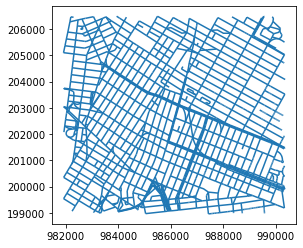

In [234]:
lion_filt.loc[(20200,20202),'rw_type']
lion_filt.plot()

In [236]:
#lion_filt[lion_filt['rw_type'] == 6]
#list(lion_clipped.columns)
#n = (lion_filt['rw_type'] == 6).to_numpy()
#lion_filt.iloc[n]
lion_clipped.dtypes #[lion_clipped['rw_type'] == 6]

lion_filt['feature_filt'] = lion_filt.apply(lambda x : (x['featuretyp'].strip() == '0') \
                                            and ((x['rw_type'].strip() == '1')
                                                 or (x['rw_type'].strip() == '2')
                                                 or (x['rw_type'].strip() == '3')
                                                 or (x['rw_type'].strip() == '4'))
                                            and (x['segmenttyp'] != 'G')
                                            and (x['segmenttyp'] != 'F'), axis = 1) 

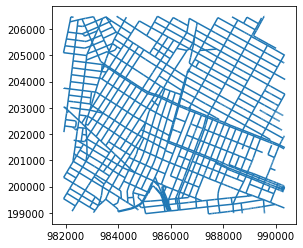

In [237]:
lion_filt2 = lion_filt[lion_filt['feature_filt']]
lion_filt2.plot()

In [33]:
G = nx.Graph()
G.add_nodes_from(nodes_clipped['nodeid'].astype(int))
edges = list(lion_filt[['nodeidfrom','nodeidto','weight']].to_records(index=False))
G.add_edges_from(edges)

In [34]:
paths_all = dict(nx.all_pairs_dijkstra_path(G,weight = 'weight'))

In [35]:
taxis_clipped = taxis_clipped[taxis_clipped['nn_pickup'] != taxis_clipped['nn_dropoff']]
taxis_clipped['datetime_pickup'] = pd.to_datetime(taxis_clipped['tpep_pickup_datetime'])
taxis_clipped['datetime_dropoff'] = pd.to_datetime(taxis_clipped['tpep_dropoff_datetime'])
taxis_clipped['trip_time'] = taxis_clipped.apply(lambda x: (x['datetime_dropoff']-x['datetime_pickup']).seconds, axis = 1)

In [63]:
def getPathData(p):
    p_seg_ids = []
    p_seg_lengths = []
    p_seg_shapes = []
    for i in np.arange(1,len(p)):
        nodes_temp = [p[i], p[i-1]]
        node_min = min(nodes_temp)
        node_max = max(nodes_temp)
        row = lion_filt.loc[(node_min,node_max)]
        p_seg_ids.append(int(row['seg_id']))
        p_seg_lengths.append(float(row['shape_length']))
        for shape in row['shape']:
            p_seg_shapes.append(shape)
    return p_seg_ids, p_seg_lengths, MultiLineString(p_seg_shapes)

In [65]:
taxis_clipped['path'] = '' 
taxis_clipped['path_distance_mi'] = 0
taxis_clipped['seg_ids'] = ''
taxis_clipped['seg_lengths'] = ''
taxis_clipped['path_shape'] = ''

trip_idx = taxis_clipped.index

for i in trip_idx:
    start_node = taxis_clipped.loc[i,'nn_pickup']
    end_node = taxis_clipped.loc[i,'nn_dropoff']
    path = paths_all[start_node][end_node]
    taxis_clipped.at[i, 'path'] = path
    seg_ids, seg_lengths, path_shape = getPathData(path)
    taxis_clipped.loc[i, 'path_distance_mi'] = np.array(seg_lengths).sum()/5280
    taxis_clipped.at[i,'seg_lengths'] = seg_lengths
    taxis_clipped.at[i, 'seg_ids'] = seg_ids
    taxis_clipped.at[i, 'path_shape'] = path_shape
    
taxis_clipped['dist_error'] = (taxis_clipped['trip_distance'] - taxis_clipped['path_distance_mi']).abs()

In [66]:
bins = np.arange(0,3.4,0.2)
labels = bins[0:-1] + 0.1

taxis_clipped['dbin'] = pd.cut(taxis_clipped['trip_distance'], bins=bins, labels = labels)
lower = taxis_clipped.groupby('dbin')['trip_time'].quantile(0.05)
upper = taxis_clipped.groupby('dbin')['trip_time'].quantile(0.95)
lower_arr = pd.DataFrame(lower).reset_index().to_numpy()
upper_arr = pd.DataFrame(upper).reset_index().to_numpy()


from scipy.interpolate import UnivariateSpline
spl_lower = UnivariateSpline(lower_arr[:,0],lower_arr[:,1])
spl_upper = UnivariateSpline(upper_arr[:,0],upper_arr[:,1])

taxis_clipped['trip_time_p5'] = taxis_clipped['trip_distance'].apply(lambda x : float(spl_lower(x)))
taxis_clipped['trip_time_p95'] = taxis_clipped['trip_distance'].apply(lambda x : float(spl_upper(x)))

In [67]:
taxis_clipped['filt'] = taxis_clipped.apply(lambda x : \
                                            (x['trip_distance'] >= 0.5) \
                                            and (x['trip_distance'] <= 2) \
                                            and (x['trip_time'] >= x['trip_time_p5']) \
                                            and (x['trip_time'] <= x['trip_time_p95']) \
                                            and (x['dist_error'] < 0.4), axis = 1)

taxis_filt = taxis_clipped[taxis_clipped['filt']].reset_index()

In [69]:
trip_filt_idx = taxis_filt.index
num_segments = lion_filt.shape[0]
A = np.zeros([len(trip_filt_idx), num_segments])

for i in trip_filt_idx:
    seg_coefs = np.zeros(num_segments)
    seg_coefs[taxis_filt.loc[i,'seg_ids']] = taxis_filt.loc[i,'seg_lengths']
    A[i] = seg_coefs

In [85]:
b = taxis_filt['trip_time'] 
lb = np.zeros(num_segments)
ub = np.ones(num_segments)*0.4

x = lsq_linear(A, b, bounds = (lb, ub))

In [75]:
x

 active_mask: array([-1,  0,  0, ...,  0,  0, -1])
        cost: 139767721.47992587
         fun: array([  56.58965638,  -73.90710326,    2.71445407, ...,  145.95494858,
        -52.80081446, -133.43150513])
     message: 'The relative change of the cost function is less than `tol`.'
         nit: 85
  optimality: 0.0038342044335001393
      status: 2
     success: True
           x: array([3.80006745e-17, 1.19838867e+01, 1.71187095e+00, ...,
       2.80267483e-01, 2.41086184e-01, 2.03533304e-14])

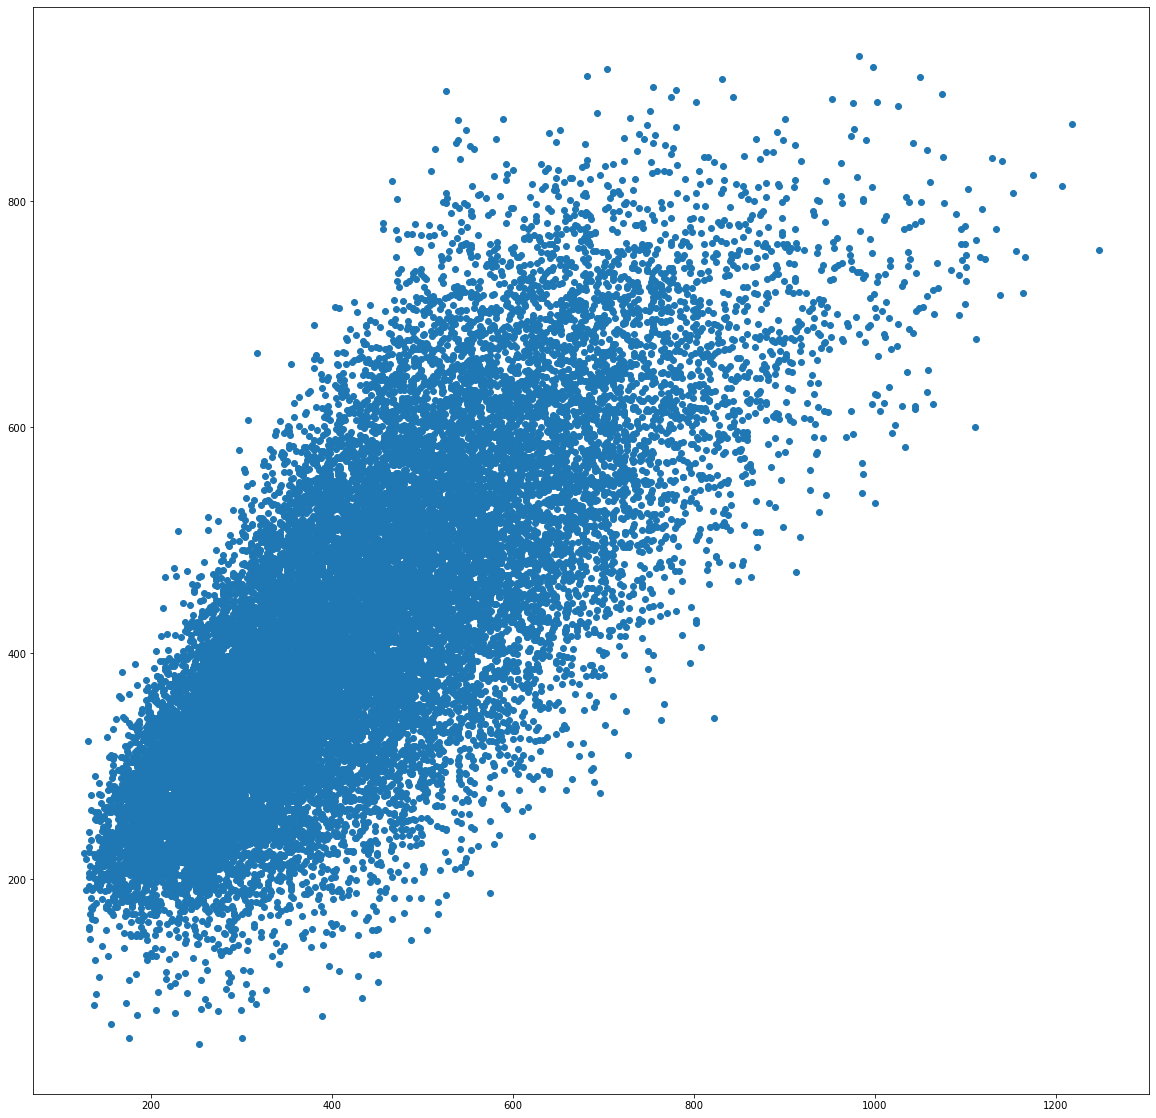

In [86]:
pred = np.matmul(A, x['x'])

plt.figure(figsize=(20,20))
plt.scatter(b, pred)

(array([ 15.,   5.,  11.,  22.,  28.,  33.,  52.,  73.,  65.,  61.,  63.,
         79.,  65.,  74.,  66.,  64.,  56.,  56.,  48.,  54.,  63.,  57.,
         44.,  46.,  51., 182.,  45.,  49.,  39.,  38.,  31.,  22.,  37.,
         29.,  23.,  25.,  15.,  25.,  27.,  14.,  19.,  13.,  16.,  21.,
         16.,  14.,  11.,   9.,  15.,  13.,  11.,  15.,  12.,  12.,   9.,
         10.,  12.,  12.,  14.,  11.,  10.,   4.,   8.,  10.,   5.,   4.,
          9.,   5.,   7.,  10.,   5.,   4.,   8.,   6.,   7.,  22.,   3.,
          6.,   4.,  10.,   7.,   8.,   8.,   7.,   8.,   5.,   3.,   7.,
          7.,   3.,  10.,  12.,   4.,   9.,   4.,   7.,   5.,   6.,   7.,
         25.]),
 array([0.   , 0.004, 0.008, 0.012, 0.016, 0.02 , 0.024, 0.028, 0.032,
        0.036, 0.04 , 0.044, 0.048, 0.052, 0.056, 0.06 , 0.064, 0.068,
        0.072, 0.076, 0.08 , 0.084, 0.088, 0.092, 0.096, 0.1  , 0.104,
        0.108, 0.112, 0.116, 0.12 , 0.124, 0.128, 0.132, 0.136, 0.14 ,
        0.144, 0.148, 0.152, 0.156

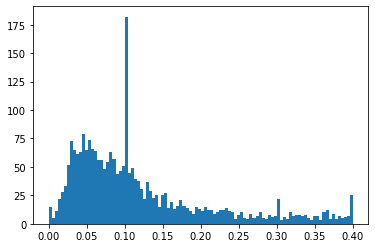

In [87]:
plt.hist(x['x'], range=[0,0.4], bins = 100)

In [88]:
##### NOW WRITE TO POSTGIS AND LOAD INTO ARCGIS
taxis_filt['velocity'] = x['x']

ValueError: Length of values does not match length of index

In [89]:
np.shape(taxis_filt)

(23648, 39)

In [90]:
np.shape(x['x'])

(2416,)

In [91]:
np.shape(lion_filt)

(2416, 121)

In [141]:
from shapely.geometry import asMultiLineString

lion_filt['velocity'] = x['x']

#s = lion_filt.iloc[0]['shape']
#WKTElement(asMultiLineString(lion_filt.iloc[0]['shape']),srid=2236)
#WKTElement(str(s))

lion_filt['shape_wkt'] = lion_filt['shape'].apply(lambda x : WKTElement(x,srid=2263))
#lion_filt

In [142]:
#countries_gdf.to_postgis(name="countries_table", con=engine)
lion_filt[['seg_id','shape_wkt','velocity']].to_sql('lion_velocity', engine, if_exists='replace', index=False,
                                       dtype={'shape_wkt': Geometry('MULTILINESTRING', srid= 2263)})

In [101]:
lion_filt[['shape','velocity']].to_postgis(name="lion_velocity", con=engine)

AttributeError: 'GeoDataFrame' object has no attribute 'to_postgis'